In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray as xr
import xbout
from pathlib import Path
import xhermes as xh
import matplotlib.pyplot as plt
import os, sys, pathlib
import numpy as np
import xarray as xr
import xhermes as xh

sys.path.append(os.path.join(r"/users/jlb647/scratch/simulation_program/hermes-3_sim/analysis/sdtools"))
sys.path.append(os.path.join(r"/users/jlb647/scratch/simulation_program/hermes-3_sim/analysis/my_notebooks/notebooks/hermes-3/general_functions"))
sys.path.append(os.path.join(r'/users/jlb647/scratch/simulation_program/hermes-3_sim/analysis/my_notebooks/notebooks/hermes-3/general_functions/source_functions.py'))

from convergence_functions import *
from plotting_functions import *
from source_functions import *

from matplotlib.ticker import LogFormatter

sys.path.append(os.path.join(r"/users/jlb647/scratch/simulation_program/hermes-3_sim/analysis/sdtools"))
sys.path.append(os.path.join(r"/users/jlb647/scratch/simulation_program/hermes-3_sim/analysis/my_notebooks/notebooks/hermes-3/transients"))
sys.path.append(os.path.join(r"/users/jlb647/scratch/simulation_program/hermes-3_sim/analysis/my_notebooks/notebooks/hermes-3/general_functions"))


from plotting_functions import *
from convergence_functions import * 

from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from hermes3.fluxes import *


# plt.style.use('ggplot')
plt.rcParams.update({'font.size': 10})
linewidth = 3
markersize = 15



# plt.style.use('ggplot')
plt.style.use('default')
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.grid'] = True
plt.rcParams.update({'font.size': 16})



%load_ext autoreload
%autoreload 2




In [2]:
SNB = xh.open('/users/jlb647/scratch/simulation_program/hermes-3_sim/simulation_dir/2024-11_week11_production/power_pulse/50%_fluence/power_and_density/SNB/base_01_steady_state_this_one')
FL = xh.open('/users/jlb647/scratch/simulation_program/hermes-3_sim/simulation_dir/2024-11_week11_production/power_pulse/50%_fluence/power_and_density/FL/base_01_steady_state_this_one')


(<Figure size 1000x600 with 2 Axes>,
 <Axes: xlabel='$S_{\\parallel}$ (m)', ylabel='Te, Ti (eV)'>)

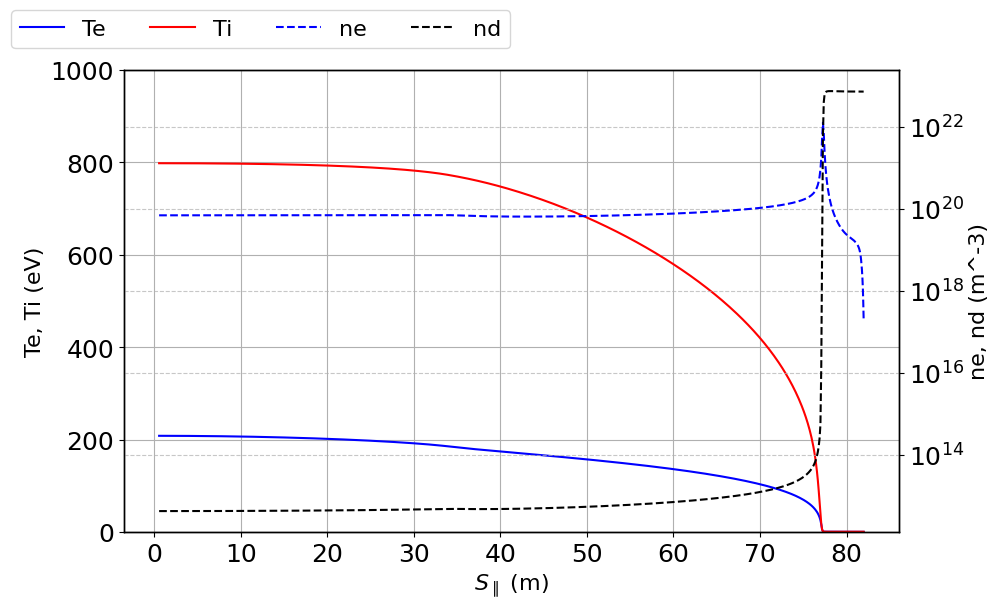

In [3]:
def te_ti_ne_nd(ds):
    # select last time step
    data = ds.isel(t=-1)

    # Extract the data arrays
    Te = replace_guards(np.squeeze(data['Te'].values))
    Ti = replace_guards(np.squeeze(data['Td+'].values))
    ne = replace_guards(np.squeeze(data['Ne'].values))
    nd = replace_guards(np.squeeze(data['Nd'].values))
    y = data['y'].values[1:-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax2 = ax.twinx()

    ax.plot(y, Te, label='Te', color='blue')
    ax.plot(y, Ti, label='Ti', color='red')

    ax2.plot(y, ne, label='ne', color='blue' , linestyle='--')
    ax2.plot(y, nd, label='nd', color='black', linestyle='--')

    ax.set_ylabel('Te, Ti (eV)')
    ax2.set_ylabel('ne, nd (m^-3)')
    ax2.set_yscale('log')
    ax.set_xlabel(r'$S_{\parallel}$ (m)')
    ax2.grid(linestyle='--', which='major', alpha=0.7)
    # ax.set_xbound(75 , 82)
    ax.set_ybound(0, 1000)
    # ax.set_xscale('log')
    fig.legend(loc = 'upper left', ncol=4)

    return fig, ax

te_ti_ne_nd(SNB)

(<Figure size 1000x600 with 2 Axes>,
 <Axes: xlabel='$S_{\\parallel}$ (m)', ylabel='Te, Ti (eV)'>)

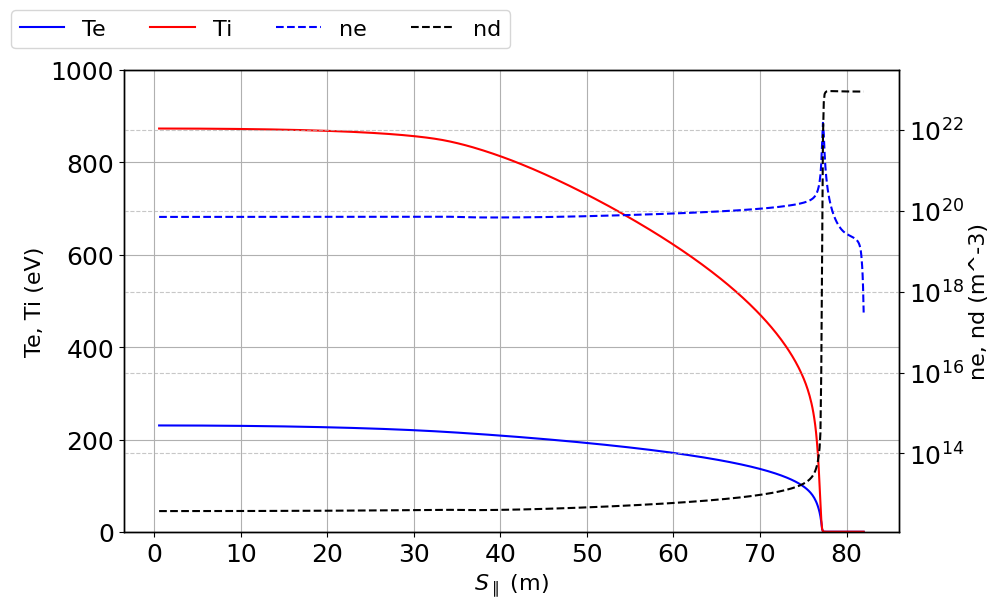

In [4]:
te_ti_ne_nd(FL)

In [5]:
SNB_300 = xh.open('/users/jlb647/scratch/simulation_program/hermes-3_sim/simulation_dir/2024-11_week11_production/power_pulse/300%_fluence/power_and_density/SNB/case_01')

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from moviepy.editor import VideoClip

def te_ti_ne_nd_with_detachment_animation(ds, front_positions, output_file="te_ti_ne_nd_detachment.mp4", plot_source = False):
    """
    Create an animation of Te, Ti, ne, nd profiles with detachment front position 
    over time and save it as an MP4.

    Parameters:
    - ds: xarray Dataset containing the data.
    - front_positions: Detachment front positions (array of floats, same length as time steps).
    - output_file: str, name of the output MP4 file.
    """
    # Extract the time and y dimension
    times = ds['t'].values * 1e3  # Convert to milliseconds
    times -= times[0]  # Normalize time to start from 0
    y = ds['y'].values[1:-1]

    def replace_guards(data):
        return data[1:-1]  # Example to remove guard cells

    # Calculate the fixed y-axis limits for the profiles
    max_Te = -np.inf
    max_Ti = -np.inf
    max_ne = -np.inf
    max_nd = -np.inf

    for t_index in range(len(times)):
        data = ds.isel(t=t_index)
        Te = replace_guards(np.squeeze(data['Te'].values))
        Ti = replace_guards(np.squeeze(data['Td+'].values))
        ne = replace_guards(np.squeeze(data['Ne'].values))
        nd = replace_guards(np.squeeze(data['Nd'].values))
        max_Te = max(max_Te, np.nanmax(Te))
        max_Ti = max(max_Ti, np.nanmax(Ti))
        max_ne = max(max_ne, np.nanmax(ne))
        max_nd = max(max_nd, np.nanmax(nd))

    # Extract the initial profiles for the semi-transparent trace
    initial_data = ds.isel(t=0)
    initial_Te = replace_guards(np.squeeze(initial_data['Te'].values))
    initial_Ti = replace_guards(np.squeeze(initial_data['Td+'].values))
    initial_ne = replace_guards(np.squeeze(initial_data['Ne'].values))
    initial_nd = replace_guards(np.squeeze(initial_data['Nd'].values))

    # Define the frame generation function
    def make_frame(t_index):
        fig, axes = plt.subplots(2, 1, figsize=(12, 12), gridspec_kw={'height_ratios': [3, 1]})
        ax, ax_detachment = axes
        ax2 = ax.twinx()

        # Extract data for the current time slice
        data = ds.isel(t=t_index)
        Te = replace_guards(np.squeeze(data['Te'].values))
        Ti = replace_guards(np.squeeze(data['Td+'].values))
        ne = replace_guards(np.squeeze(data['Ne'].values))
        nd = replace_guards(np.squeeze(data['Nd'].values))

        # Plot initial profiles as semi-transparent traces
        ax.plot(y, initial_Te, color='blue', alpha=0.5, linestyle='-')
        ax.plot(y, initial_Ti, color='red', alpha=0.5, linestyle='-')
        ax2.plot(y, initial_ne, color='blue', alpha=0.5, linestyle='--')
        ax2.plot(y, initial_nd, color='black', alpha=0.5, linestyle='--')

        # Plot profiles for the current time slice
        ax.plot(y, Te, label='Te', color='blue')
        ax.plot(y, Ti, label='Ti', color='red')
        ax2.plot(y, ne, label='ne', color='blue', linestyle='--')
        ax2.plot(y, nd, label='nd', color='black', linestyle='--')

        # Set axis limits
        ax.set_ylim(0, 2e3)
        ax2.set_ylim(1e14, max(max_ne, max_nd))

        # Set labels
        ax.set_ylabel('Te, Ti (eV)')
        ax2.set_ylabel('ne, nd (m^-3)')
        ax2.set_yscale('log')
        ax2.grid(True, linestyle=':')
        ax.set_xlabel(r'$S_{\parallel}$ (m)')
        ax.set_title(f'Time: {times[t_index]:.2f} ms')

        # Plot detachment front position on the second row
        ax_detachment.plot(times, front_positions, label="Detachment Front Position", color="blue")
        ax_detachment.axvline(times[t_index], color='red', linestyle='--', label="Current Time Step")

        if plot_source:
            # Plot the source term
            source = np.squeeze(data['Pe_src'].values)[:,1]
            ax_source = ax_detachment.twinx()
            ax_source.plot(y, source, label='Pressure source', color='black', linestyle='--')
            ax_source.set_ylabel('Pressure ource (W/m^3)')

        # Set detachment plot labels
        ax_detachment.set_ylabel("Detachment Front Position (m)")
        ax_detachment.set_xlabel("Time (ms)")
        
        # ax_detachment.legend(loc='upper left')

        # Add legend for the top row
        ax.legend(loc='upper left')
        ax2.legend(loc='upper right')

        # Convert the figure to an image
        fig.tight_layout()
        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)
        return img

    # Define the video duration and frame rate
    duration = len(times) / 10  # Assume 10 frames per second
    fps = 10

    step = 10  # Only include every 10th time step
    sampled_times = times[::step]
    sampled_front_positions = front_positions[::step]


    def make_frame_video(t):
        t_index = int(t * fps)  # Get the frame index
        t_index = min(t_index, len(sampled_times) - 1)  # Ensure within bounds
        return make_frame(t_index * step)  # Multiply by step to map back to full time step indices


    animation = VideoClip(make_frame_video, duration=duration)
    animation.write_videofile(output_file, fps=fps, codec="libx264")

    print(f"Animation saved to {output_file}")

# Example usage:
# front_positions, _ = detachment_front_position(FL_100)
# te_ti_ne_nd_with_detachment_animation(FL_100, front_positions, output_file="te_ti_ne_nd_detachment.mp4")


In [7]:
import numpy as np

def detachment_front_position(ds):
    """
    Calculate the detachment front position for each time step in the dataset.

    Parameters:
    ds (xarray.Dataset): The dataset containing 'Ne', 'Nd', 't', and 'y'.

    Returns:
    tuple: A tuple containing:
        - front_positions (np.ndarray): Detachment front positions for each time step.
        - front_indices (np.ndarray): Indices of the detachment front for each time step.
    """
    # Extract variables
    t = ds['t'].values
    # t -= t[0]  # Normalize time to start from 0
    # t *= 1e3  # Convert to milliseconds
    Ne = np.squeeze(ds['Ne'].values)  # Ensure correct dimensions
    Nd = np.squeeze(ds['Nd'].values)
    y = ds['y'].values[1:-1]  # Exclude guard cells

    # Initialize an array to store detachment front indices
    front_indices = np.zeros(len(t), dtype=int)  # Use int for indices

    # Loop over each time step and find the index where Nd > Ne
    for i in range(len(t)):
        detachment_mask = Nd[i, :] > Ne[i, :]  # Create mask for Nd > Ne
        if np.any(detachment_mask):  # Check if any value satisfies the condition
            front_indices[i] = np.argmax(detachment_mask)  # Find the first index
        else:
            front_indices[i] = -1  # Set to -1 if no detachment is found

    # Calculate detachment front positions relative to y[-1]
    front_positions = np.where(front_indices >= 0, y[-1] - y[front_indices], np.nan)

    return front_positions, front_indices


In [16]:
SNB_300_trimmed = SNB_300.sel(t=slice(0, 1500))

In [8]:
front_positions, _ = detachment_front_position(SNB_300)

In [20]:
te_ti_ne_nd_with_detachment_animation(SNB_300, front_positions, output_file="SNB_density_300%.mp4")